# 11 空間構造のある階層ベイズモデル

In [192]:
using CSV
using DataFrames
using Distributed
using Distributions
using ForneyLab
using LinearAlgebra
using Mamba
using Plots
using Statistics

## 11.1 例題 : 一次元空間上の個体数分布 

In [2]:
df = CSV.read("data/section11.csv")
disallowmissing!(df)

,y,m
,Int64,Float64
1,0,2.15498
2,3,3.25417
3,2,4.62867
4,5,6.23412
5,6,7.99073
6,16,9.79447
7,8,11.5334
8,14,13.1043
9,11,14.4263


### 例題の一次元空間上の架空データ
横軸は調査区間の位置, 縦軸は観測された個体数, 破線はデータをポアソン乱数で生成するときに使った平均値

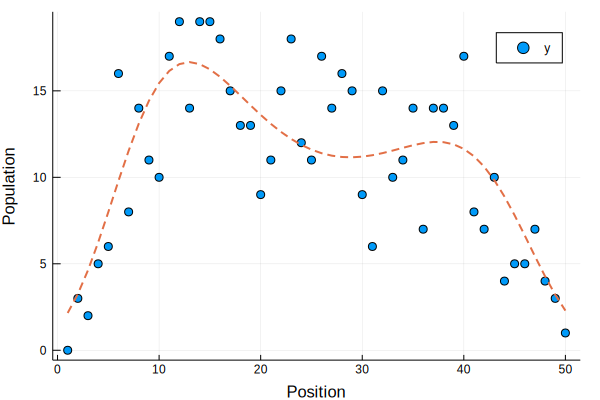

In [3]:
scatter(1:50, df.y, xlabel = "Position", ylabel = "Population", label = "y")
plot!(1:50, df.m, linewidth = 2, linestyle = :dash, label = "")

## 11.3 空間統計モデルをデータに当てはめる
### Intrinsic Gaussian CARモデル
CARモデルのPyMC3実装を参考にして, Intrinsic Gaussian CARモデルを実装する.   
https://docs.pymc.io/notebooks/PyMC3_tips_and_heuristic.html

参考文献:
Exact sparse CAR models in Stan. Max Joseph. August 20, 2016  
https://mc-stan.org/users/documentation/case-studies/mbjoseph-CARStan.html

de oliveira, Victor. (2012). Bayesian analysis of conditional autoregressive models. Annals of the Institute of Statistical Mathematics. 64. 107-133. 10.1007/s10463-010-0298-1.   
https://www.ism.ac.jp/editsec/aism/pdf/10463_2010_Article_298.pdf

Intrinsic Gaussian CAR model:
\begin{align}
y_i \mid \{y_j : j \neq i\} \sim \text{Normal}(\alpha\Sigma_{j\neq i} b_{ij}y_j, \tau_i^{-1}).
\end{align}
ここで, $y_i$ は観測データ, $B=(b_{ij})$ は scaled adjacency matrix.
$m_i=i$の近傍場所数とし、$D=(\text{diag}(m_i)), \ W=(w_{ij})$ を $w_{ii}=0$, $i$ と $j$が隣接していたら $w_{ij}=1$, 隣接していなければ $w_{ij}=0$を満たすような adjacency matrix とすると, $B=D^{-1}W$ である.

同時分布は
\begin{align}
y \sim \text{Normal}(0, [\tau (D - \alpha W)]^{-1}).
\end{align}
で与えられる.

#### Lip cancer riskデータ
まずは同様にScotlandのLip cancer risk dataを準備する. 元データは  
Kemp I. (1989) Scottish Cancer Incidence Atlas 1985. In: Boyle P., Muir C.S., Grundmann E. (eds) Cancer Mapping. Recent Results in Cancer Research, vol 114. Springer, Berlin, Heidelberg

Lip cancer rates $O_i$ は AFF (population employed in agriculture, fishing, or forestry) $a_i$, 場所差パラメーター $y_i$, expected rates $E$ を用いて
\begin{align}
O_i &\sim \text{Poisson}(\lambda_i), \\
\log \lambda_i & = \beta_0 + \beta_1 a_i + y_i + \log E_i
\end{align}
と表される. 


observed : $O_i$, expected : $E_i$, aff : $a_i$に対応している。

In [4]:
observed = [9, 39, 11, 9, 15, 8, 26, 7, 6, 20, 13, 5, 3, 8, 17, 9, 2, 7, 9, 7, 16,
            31, 11, 7, 19, 15, 7, 10, 16, 11, 5, 3, 7, 8, 11, 9, 11, 8, 6, 4, 10,
            8, 2, 6, 19, 3, 2, 3, 28, 6, 1, 1, 1, 1, 0, 0]

expected = [1.4, 8.7, 3.0, 2.5, 4.3, 2.4, 8.1, 2.3, 2.0, 6.6, 4.4, 1.8, 1.1, 3.3,
              7.8, 4.6, 1.1, 4.2, 5.5, 4.4, 10.5, 22.7, 8.8, 5.6, 15.5, 12.5, 6.0,
              9.0, 14.4, 10.2, 4.8, 2.9, 7.0, 8.5, 12.3, 10.1, 12.7, 9.4, 7.2, 5.3,
              18.8, 15.8, 4.3, 14.6, 50.7, 8.2, 5.6, 9.3, 88.7, 19.6, 3.4, 3.6, 5.7,
              7.0, 4.2, 1.8]

log_expected = log.(expected)

aff = [16, 16, 10, 24, 10, 24, 10, 7, 7, 16, 7, 16, 10, 24, 7, 16, 10, 7,
        7, 10, 7, 16, 10, 7, 1, 1, 7, 7, 10, 10, 7, 24, 10, 7, 7, 0, 10, 1,
        16, 0, 1, 16, 16, 0, 1, 7, 1, 1, 0, 1, 1, 0, 1, 1, 16, 10] ./ 10;

Spatial adjacency matrix $W=(w_{ij})_{i,j}$

In [5]:
adj = [[5, 9, 11,19],
        [7, 10],
        [6, 12],
        [18,20,28],
        [1, 11,12,13,19],
        [3, 8],
        [2, 10,13,16,17],
        [6],
        [1, 11,17,19,23,29],
        [2, 7, 16,22],
        [1, 5, 9, 12],
        [3, 5, 11],
        [5, 7, 17,19],
        [31,32,35],
        [25,29,50],
        [7, 10,17,21,22,29],
        [7, 9, 13,16,19,29],
        [4,20, 28,33,55,56],
        [1, 5, 9, 13,17],
        [4, 18,55],
        [16,29,50],
        [10,16],
        [9, 29,34,36,37,39],
        [27,30,31,44,47,48,55,56],
        [15,26,29],
        [25,29,42,43],
        [24,31,32,55],
        [4, 18,33,45],
        [9, 15,16,17,21,23,25,26,34,43,50],
        [24,38,42,44,45,56],
        [14,24,27,32,35,46,47],
        [14,27,31,35],
        [18,28,45,56],
        [23,29,39,40,42,43,51,52,54],
        [14,31,32,37,46],
        [23,37,39,41],
        [23,35,36,41,46],
        [30,42,44,49,51,54],
        [23,34,36,40,41],
        [34,39,41,49,52],
        [36,37,39,40,46,49,53],
        [26,30,34,38,43,51],
        [26,29,34,42],
        [24,30,38,48,49],
        [28,30,33,56],
        [31,35,37,41,47,53],
        [24,31,46,48,49,53],
        [24,44,47,49],
        [38,40,41,44,47,48,52,53,54],
        [15,21,29],
        [34,38,42,54],
        [34,40,49,54],
        [41,46,47,49],
        [34,38,49,51,52],
        [18,20,24,27,56],
        [18,24,30,33,45,55]];

adjの行列への展開

In [6]:
N = length(adj)

56

In [7]:
W = zeros(Int64, N, N)
for (i, a) in enumerate(adj)
   W[i, a] .= 1 
end
W

56×56 Array{Int64,2}:
 0  0  0  0  1  0  0  0  1  0  1  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  1  0  0  1  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  1  0  0  0  0  0  1  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  1  1  1     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  1  0  0  0  0  1  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  1  0  0  0  0  0  0  0  1  0  0  1     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  1  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  1  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  1  0  0  0  0  1  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  1  0  0  0  1  0  0  1  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  1  0  1  0  0  0  0  0  1  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  1  0  1  0  0  0  0  0  0    

$D=(\text{diag}(m_i)):$

In [8]:
D = Diagonal(length.(adj))

56×56 Diagonal{Int64,Array{Int64,1}}:
 4  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  2  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  2  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  3  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  5  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  2  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  5  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  6  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  4  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  4  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  3  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅

#### まずは空間統計モデルなしでやってみる

In [35]:
model = Model(
    beta0 = Stochastic(() -> Normal(0.0, 1.0)),
    beta1 = Stochastic(() -> Normal(0.0, 1.0)),
    
    mu = Logical(1, 
        (beta0, beta1, aff, log_offset) -> exp.(beta0 .+ beta1 .* aff .+ log_offset)
    ),
    
    y = Stochastic(1,
        (mu, N) -> UnivariateDistribution[Poisson(mu[i]) for i in 1:N],
        false
    )
)

Object of type "Model"
-------------------------------------------------------------------------------
beta0:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
mu:
A monitored node of type "0-element ArrayLogical{1}"
Float64[]
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
beta1:
A monitored node of type "ScalarStochastic"
NaN


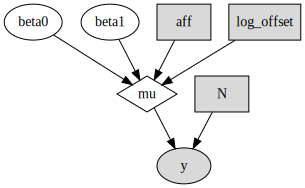

In [36]:
display("image/svg+xml", ForneyLab.dot2svg(graph2dot(model)))

In [37]:
data = Dict{Symbol, Any}(
    :log_offset => log_expected,
    :aff => aff,
    :N => N,
    :y => observed
)

Dict{Symbol,Any} with 4 entries:
  :aff        => [1.6, 1.6, 1.0, 2.4, 1.0, 2.4, 1.0, 0.7, 0.7, 1.6  …  0.1, 0.1…
  :N          => 56
  :y          => [9, 39, 11, 9, 15, 8, 26, 7, 6, 20  …  2, 3, 28, 6, 1, 1, 1, 1…
  :log_offset => [0.336472, 2.16332, 1.09861, 0.916291, 1.45862, 0.875469, 2.09…

In [158]:
inits = [
    Dict{Symbol, Any}(
        :beta0 => 1.0,
        :beta1 => 1.0,
        
        :mu => observed,
        
        :y => observed,
    ) for i in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:beta0=>1.0,:mu=>[9, 39, 11, 9, 15, 8, 26, 7, 6, 20  …  2, 3, 28, 6, 1, 1, 1, 1, 0, 0],:y=>[9, 39, 11, 9, 15, 8, 26, 7, 6, 20  …  2, 3, 28, 6, 1, 1, 1, 1, 0, 0],:beta1=>1.0)
 Dict(:beta0=>1.0,:mu=>[9, 39, 11, 9, 15, 8, 26, 7, 6, 20  …  2, 3, 28, 6, 1, 1, 1, 1, 0, 0],:y=>[9, 39, 11, 9, 15, 8, 26, 7, 6, 20  …  2, 3, 28, 6, 1, 1, 1, 1, 0, 0],:beta1=>1.0)
 Dict(:beta0=>1.0,:mu=>[9, 39, 11, 9, 15, 8, 26, 7, 6, 20  …  2, 3, 28, 6, 1, 1, 1, 1, 0, 0],:y=>[9, 39, 11, 9, 15, 8, 26, 7, 6, 20  …  2, 3, 28, 6, 1, 1, 1, 1, 0, 0],:beta1=>1.0)

In [159]:
scheme = [
    AMWG([:beta0, :beta1], 1.0), 
]

1-element Array{Sampler{Mamba.AMWGTune},1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:beta0, :beta1]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any


In [160]:
setsamplers!(model, scheme)
sim = mcmc(model, data, inits, 12500, burnin=2500, thin=5, chains=3)

MCMC Simulation of 12500 Iterations x 3 Chains...

Chain 1:   0% [0:00:08 of 0:00:08 remaining]
Chain 1:  10% [0:00:01 of 0:00:02 remaining]
Chain 1:  20% [0:00:01 of 0:00:01 remaining]
Chain 1:  30% [0:00:01 of 0:00:01 remaining]
Chain 1:  40% [0:00:01 of 0:00:01 remaining]
Chain 1:  50% [0:00:01 of 0:00:01 remaining]
Chain 1:  60% [0:00:01 of 0:00:01 remaining]
Chain 1:  70% [0:00:00 of 0:00:01 remaining]
Chain 1:  80% [0:00:00 of 0:00:01 remaining]
Chain 1:  90% [0:00:00 of 0:00:01 remaining]
Chain 1: 100% [0:00:00 of 0:00:01 remaining]

Chain 2:   0% [0:00:03 of 0:00:03 remaining]
Chain 2:  10% [0:00:01 of 0:00:01 remaining]
Chain 2:  20% [0:00:01 of 0:00:01 remaining]
Chain 2:  30% [0:00:01 of 0:00:01 remaining]
Chain 2:  40% [0:00:01 of 0:00:01 remaining]
Chain 2:  50% [0:00:01 of 0:00:01 remaining]
Chain 2:  60% [0:00:00 of 0:00:01 remaining]
Chain 2:  70% [0:00:00 of 0:00:01 remaining]
Chain 2:  80% [0:00:00 of 0:00:01 remaining]
Chain 2:  90% [0:00:00 of 0:00:01 remaining]
Cha

Object of type "ModelChains"

Iterations = 2505:12500
Thinning interval = 5
Chains = 1,2,3
Samples per chain = 2000

[0.809153 -0.610156 … 8.32758 2.19632; 0.809153 -0.610156 … 8.32758 2.19632; … ; 0.644157 -0.514597 … 7.0367 2.04899; 0.669048 -0.424572 … 8.01239 2.29851]

[0.686562 -0.490357 … 7.71547 2.1902; 0.686562 -0.490357 … 7.71547 2.1902; … ; 0.74272 -0.581919 … 7.70229 2.11401; 0.697863 -0.508686 … 7.71355 2.17486]

[0.651623 -0.571098 … 6.73005 1.95094; 0.651623 -0.571098 … 6.73005 1.95094; … ; 0.657094 -0.487242 … 7.38309 2.13323; 0.780943 -0.595995 … 8.07358 2.16568]

In [161]:
describe(sim)

Iterations = 2505:12500
Thinning interval = 5
Chains = 1,2,3
Samples per chain = 2000

Empirical Posterior Estimates:
           Mean         SD        Naive SE       MCSE        ESS   
 beta1  0.73323625 0.058742049 0.00075835659 0.0015893160 1366.0849
 beta0 -0.53946779 0.068840912 0.00088873236 0.0017802747 1495.2685
 mu[1]  2.64295318 0.154634001 0.00199631636 0.0029026806 2000.0000
 mu[2] 16.42406617 0.960939861 0.01240568026 0.0180380868 2000.0000
 mu[3]  3.64481912 0.156789847 0.00202414823 0.0023993793 2000.0000
 mu[4]  8.51031202 0.823470061 0.01063095277 0.0189215782 1894.0041
 mu[5]  5.22424074 0.224732115 0.00290127912 0.0034391104 2000.0000
 mu[6]  8.16989954 0.790531258 0.01020571466 0.0181647151 1894.0041
 mu[7]  9.84101162 0.423332588 0.00546520021 0.0064783242 2000.0000
 mu[8]  2.24274990 0.100029445 0.00129137458 0.0018966359 2000.0000
 mu[9]  1.95021730 0.086982126 0.00112293441 0.0016492486 2000.0000
mu[10] 12.45963641 0.728988860 0.00941120572 0.0136840659 2000.000

In [162]:
p = Mamba.plot(sim, legend = true);

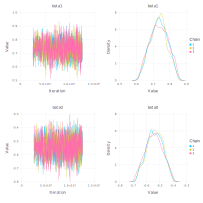

In [163]:
Mamba.draw(p[:, 1:2], nrow = 2, ncol = 2)

In [196]:
sim_mu = sim[:, [:mu], :].value
sim_mu = reshape(sim_mu, (size(sim_mu, 1) * size(sim_mu, 3), size(sim_mu, 2)))

6000×56 Array{Float64,2}:
 2.77586  9.46973   9.88344  13.0862   1.3422   …   5.60735  2.05     4.22059
 2.77586  9.46973   9.88344  13.0862   1.3422       5.60735  2.05     4.22059
 2.77586  9.46973   9.88344  13.0862   1.3422       5.74798  2.10141  4.32643
 2.74213  9.29766   9.80821  12.9272   1.33198      5.74798  2.10141  4.32643
 2.73061  9.2586    9.76701  12.8729   1.32638      5.74798  2.10141  4.32643
 2.73061  9.2586    9.76701  12.8729   1.32638  …   6.29485  2.30134  4.73806
 2.62468  8.89942   9.3881   12.3735   1.27493      6.263    2.2897   4.71409
 2.62468  8.89942   9.3881   12.3735   1.27493      6.263    2.2897   4.71409
 2.75366  9.56344   9.67386  12.9816   1.31373      6.21424  2.27187  4.67738
 2.5739   8.67498   9.24803  12.1341   1.25591      6.23188  2.27832  4.69066
 2.59633  8.75058   9.32863  12.2398   1.26685  …   6.79172  2.48299  5.11205
 2.59633  8.75058   9.32863  12.2398   1.26685      6.73793  2.46333  5.07156
 2.81249  9.54239  10.055    13.2589  

In [206]:
mu_prob = map(x -> mean!(ones((1, N)), pdf.(Poisson.(sim_mu), x)), 1:50)

50-element Array{Array{Float64,2},1}:
 [0.0945065 0.0111354 … 0.204121 0.101616]          
 [0.14031 0.0310687 … 0.238822 0.133534]            
 [0.142764 0.0596468 … 0.196813 0.133552]           
 [0.112091 0.0893921 … 0.129933 0.119156]           
 [0.0725235 0.112404 … 0.0736581 0.102696]          
 [0.0405824 0.12413 … 0.0372254 0.0877098]          
 [0.0209927 0.123915 … 0.0170783 0.0739435]         
 [0.011803 0.113744 … 0.00716811 0.0606396]         
 [0.00948026 0.096888 … 0.00276251 0.0476204]       
 [0.0111898 0.0769517 … 0.000980369 0.0353701]      
 [0.0150867 0.0571482 … 0.00032143 0.0246602]       
 [0.0199329 0.0397785 … 9.77341e-5 0.0160864]       
 [0.0247587 0.026016 … 2.76727e-5 0.00981628]       
 ⋮                                                  
 [6.60275e-7 2.64448e-13 … 2.02769e-26 3.03294e-15] 
 [2.90912e-7 6.8948e-14 … 2.0711e-27 6.60943e-16]   
 [1.25391e-7 1.76104e-14 … 2.06947e-28 1.40872e-16] 
 [5.29024e-8 4.4081e-15 … 2.02399e-29 2.93821e-17]  
 [2.1858

In [205]:
mu_1 = vec(sim[:, [:mu], :].value[:, 1, :])
mu_1_prob = map(x -> mean(pdf.(Poisson.(mu_1), x)), 0:50)

51-element Array{Float64,1}:
 0.07200275447917907   
 0.18858971950761716   
 0.24782653451090333   
 0.2178561793334765    
 0.14412164192327925   
 0.0765326389699055    
 0.03398154415379611   
 0.012976115853101362  
 0.00435008691386188   
 0.001300569513678939  
 0.0003511056359018338 
 8.645026575768122e-5  
 1.957554735653724e-5  
 ⋮                     
 7.387616545547576e-31 
 5.42123676735865e-32  
 3.8893149531399473e-33
 2.729375059919012e-34 
 1.8745250037696878e-35
 1.2605744473761011e-36
 8.304164307600708e-38 
 5.361234662771058e-39 
 3.3935750328212366e-40
 2.1069188757078092e-41
 1.2835183538366595e-42
 7.675014644128961e-44 

In [171]:
categorical_mu_1 = Distributions.Categorical(mu_1_prob)

Distributions.Categorical{Float64}(
K: 51
p: [1.15221e-7, 1.79109e-6, 1.39687e-5, 7.28759e-5, 0.000286124, 0.000901767, 0.00237645, 0.00538627, 0.0107183, 0.0190228  …  3.59588e-7, 1.51381e-7, 6.2412e-8, 2.52122e-8, 9.98399e-9, 3.87745e-9, 1.47749e-9, 5.52602e-10, 2.02946e-10, 7.32134e-11]
)


In [172]:
quantile(categorical_mu_1, 0.025) - 1

9

In [173]:
median(categorical_mu_1) - 1 

16

In [174]:
quantile(categorical_mu_1, 0.975) - 1

25

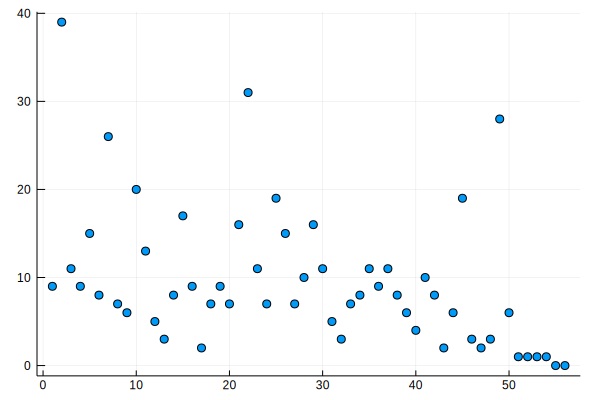

In [165]:
scatter(1:N, observed, label = "")

#### 空間統計モデルを実装する

In [19]:
model = Model(
    beta0 = Stochastic(() -> Normal(0.0, 1.0)),
    beta1 = Stochastic(() -> Normal(0.0, 1.0)),
    
#     tau = Stochastic(() -> Mamba.Gamma(2.0, 2.0)),
#     alpha = Stochastic(() -> Uniform(0, 1)),
#     phi = Stochastic(1,
#         (tau, alpha, N, D, W) -> MvNormal(zeros(N), tau * (D - alpha * W)),
#         false
#     ),
    
#     mu = Logical(1, 
#         (beta0, beta1, aff, phi, log_offset) -> @.exp(beta0 + beta1 * aff + phi + log_offset),
#         false
#     ),
    
    mu = Logical(1, 
        (beta0, beta1, aff, log_offset) -> exp.(beta0 .+ beta1 .* aff .+ log_offset),
        false
    ),
    
    y = Stochastic(1,
        (mu, N) -> UnivariateDistribution[Poisson(mu[i]) for i in 1:N],
        false
    )
)

Object of type "Model"
-------------------------------------------------------------------------------
beta0:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
mu:
An unmonitored node of type "0-element ArrayLogical{1}"
Float64[]
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
beta1:
A monitored node of type "ScalarStochastic"
NaN


In [20]:
scheme = [
    AMWG([:beta0, :beta1], 1.0), 
#     Slice(:alpha, 10.0),
#     Slice(:tau, 10.0)
]

1-element Array{Sampler{Mamba.AMWGTune},1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:beta0, :beta1]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any


In [21]:
inits = [
    Dict{Symbol, Any}(
        :beta0 => 1.0,
        :beta1 => 1.0,

#         :tau => 1.0,
#         :alpha => 0.5,
#         :phi => rand(Normal(0.0, 1.0), N),
        
        :mu => exp.(log_expected),
        
        :y => observed,
    ) for i in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:beta0=>1.0,:mu=>[1.4, 8.7, 3.0, 2.5, 4.3, 2.4, 8.1, 2.3, 2.0, 6.6  …  5.6, 9.3, 88.7, 19.6, 3.4, 3.6, 5.7, 7.0, 4.2, 1.8],:y=>[9, 39, 11, 9, 15, 8, 26, 7, 6, 20  …  2, 3, 28, 6, 1, 1, 1, 1, 0, 0],:beta1=>1.0)
 Dict(:beta0=>1.0,:mu=>[1.4, 8.7, 3.0, 2.5, 4.3, 2.4, 8.1, 2.3, 2.0, 6.6  …  5.6, 9.3, 88.7, 19.6, 3.4, 3.6, 5.7, 7.0, 4.2, 1.8],:y=>[9, 39, 11, 9, 15, 8, 26, 7, 6, 20  …  2, 3, 28, 6, 1, 1, 1, 1, 0, 0],:beta1=>1.0)
 Dict(:beta0=>1.0,:mu=>[1.4, 8.7, 3.0, 2.5, 4.3, 2.4, 8.1, 2.3, 2.0, 6.6  …  5.6, 9.3, 88.7, 19.6, 3.4, 3.6, 5.7, 7.0, 4.2, 1.8],:y=>[9, 39, 11, 9, 15, 8, 26, 7, 6, 20  …  2, 3, 28, 6, 1, 1, 1, 1, 0, 0],:beta1=>1.0)

In [22]:
scheme = [
    AMWG([:beta0, :beta1], 1.0), 
#     Slice(:alpha, 10.0),
#     Slice(:tau, 10.0)
]

1-element Array{Sampler{Mamba.AMWGTune},1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:beta0, :beta1]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any
